<a href="https://colab.research.google.com/github/Nambu89/Entregable_RL_Frozen_Lake_Master_DataScience/blob/main/DSCESP1023_Actividad_RL_Grupo_05_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulo Deep Learning
## Actividad 2: Reinforcement Learning: **Frozen lake problem**

Fernando Prada Gorgé

Stefany Apolo

Ana Belén Alcaide


# Actividad Reinforcemente Learning

Resolver el problema del Frozen lake de OpenAI Gym. Documentación: https://www.gymlibrary.dev/environments/toy_text/frozen_lake/

## Objetivos
- Conseguir movermos aleatoriamente hasta cumplir el objetivo
- Conseguir que el agente aprenda con Q-learning
- (Opcional) Probar con otros hiperparámetros
- (Opcional) Modificar la recompensa

## Consideraciones
- No hay penalizaciones
- Si el agente cae en un "hole", entonces done = True y se queda atascado sin poder salir (al igual que ocurre cuando llega al "goal")

## Normas a seguir

- Se debe entregar un **ÚNICO GOOGLE COLAB notebook** (archivo .ipynb) que incluya las instrucciones presentes y su **EJECUCIÓN!!!**.
- Poner el nombre del grupo en el nombre del archivo y el nombre de todos los integrantes del grupo al inicio del notebook.

## Criterio de evaluación

- Seguimiento de las normas establecidas en la actividad.
- Corrección en el uso de algoritmos, modelos y formas idiomáticas en Python.
- El código debe poder ejecutarse sin modificación alguna en Google Colaboratory.

## **Instalamos librerías**

In [1]:
!pip install gym==0.17.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.6 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654618 sha256=6e1906f3b5cacd75337060ac96658518116c65b848181151b2aa3cac960f614e
  Stored in directory: /root/.cache/pip/wheels/af/4b/74/fcfc8238472c34d7f96508a63c962ff3ac9485a9a4137afd4e
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Uninstalling cloudpickle-2.2.1:
      Successfully uninstalled cloudpickle-2.2.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.0.0 requires cloudpickl

In [2]:
import gym
import numpy as np
from time import sleep
from IPython.display import clear_output
import random as rd
import matplotlib.pyplot as plt
import time
import seaborn as sns

##**Definición del entorno**

In [3]:
# Definimos el entorno
env = gym.make('FrozenLake-v0', desc=None, map_name="4x4", is_slippery=False)

In [4]:
# Fijamos una semilla
seed_value = 42
env.seed(seed_value)
np.random.seed(seed_value)

In [5]:
env.reset() # En este caso, empieza desde la misma posición inicial
print(env.render())


SFFF
FHFH
FFFH
HFFG
None


### **Rewards Schedule**:

*   Reach goal (G): +1
*   Reach hole (H): 0
*   Reach frozen (F): 0

In [6]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(4)
State Space Discrete(16)


Acciones posibles:
* 0: izquierda
* 1: abajo
* 2: derecha
* 3: arriba

In [7]:
# Identificador de estado
state = env.s
print("State:", state)

State: 0


## **¡Nos movemos aleatoriamente!**

In [8]:
steps = 0
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [9]:
# Acciones: 0=izquierda, 1=abajo, 2=derecha, 3=arriba
action = 1
state, reward, done, info = env.step(action)

print("State:", state)
print(state, reward, done, info)

env.s = state
env.render()

steps += 1

print(f"Step: {steps}")

State: 4
4 0.0 False {'prob': 1.0}
  (Down)
SFFF
FHFH
FFFH
HFFG
Step: 1


### Podemos observar los valores predeterminados de recompensa asignados al estado:

Por ejemplo, para el estado 14, su salida es un diccionario.

Las claves del diccionario, 0, 1, 2, 3, corresponden a las acciones que podemos tomar desde el estado 14. Cada acción incluye una lista, donde cada elemento de la lista es una tupla que muestra la probabilidad de transición al estado siguiente, el estado siguiente, la recompensa y si se completa la acción (done=True si el estado siguiente es un Agujero o la Meta). Así, env.P es una lista que contiene todos los estados, donde cada estado incluye un diccionario que mapea todas las acciones posibles desde ese estado al siguiente, la probabilidad de transitar a ese estado siguiente, la recompensa y si el juego termina allí o no.

Movimiento, probabilidad, recompensa, indicador.

In [10]:
env.P[14]

{0: [(1.0, 13, 0.0, False)],
 1: [(1.0, 14, 0.0, False)],
 2: [(1.0, 15, 1.0, True)],
 3: [(1.0, 10, 0.0, False)]}

### Porqué usamos Q-Learning en lugar de K-armed Bandit:



*   **Naturaleza del Problema:**

**Q-Learning:** Es un método de aprendizaje por refuerzo que está diseñado para problemas con estados y acciones claramente definidos, como el "Frozen Lake". Q-learning busca aprender una política de acciones que maximiza las recompensas totales futuras, considerando los estados actuales y las transiciones posibles.

**K-armed Bandit:** Es un modelo más simple de aprendizaje por refuerzo que se utiliza típicamente en situaciones donde sólo se tiene que elegir entre varias opciones (o "brazos") sin tener en cuenta un estado ambiental. No se consideran las transiciones de estado ni la dinámica del entorno a lo largo del tiempo.

* **Complejidad del Entorno:**

En "Frozen Lake", el agente debe aprender no solo qué acciones tomar, sino también cómo las acciones afectan el cambio de un estado a otro bajo incertidumbre. Q-learning permite al agente aprender una política que optimiza las recompensas a largo plazo teniendo en cuenta la probabilidad de cada transición de estado.

Los algoritmos de k-armed bandit, por otro lado, simplemente se centran en aprender cuál de las opciones disponibles ofrece, en promedio, la mejor recompensa. No están diseñados para aprender o manejar transiciones de estado complejas o la dinámica del entorno.

* **Aplicabilidad:**

Para problemas donde el contexto o el estado no influyen en la decisión, un algoritmo tipo k-armed bandit sería adecuado y más simple de implementar. Sin embargo, en un entorno dinámico y contextual como "Frozen Lake", donde las decisiones deben adaptarse en función de los estados cambiantes del entorno, Q-learning es mucho más efectivo.



### Aprendizaje sin usar Q-Learning

In [11]:
class bcolors:
    RED= '\u001b[31m'
    GREEN= '\u001b[32m'
    RESET= '\u001b[0m'

env.s = 0
timestep, penalties, reward = 0, 0, 0
done = False

while reward == 0:

    if done is True:
        env.reset()

    action = env.action_space.sample() # con "sample" elegimos una de las acciones del action_space
    state, reward, done, info = env.step(action) # con "step" realizamos la acción elegida


    if reward == 0:
        penalties += 1

    timestep += 1

  # Print each step
    clear_output(wait=True)
    env.render()
    print("")
    if reward < 0:
        print(f"Recompensa actual: {bcolors.RED}{reward}{bcolors.RESET}")
    else:
        print(f"Recompensa actual: {bcolors.GREEN}{reward}{bcolors.RESET}")
    print("")
    print('Estado actual', state)
    sleep(0.05)


print("Timesteps taken: {}".format(timestep))
print("Penalties incurred: {}".format(penalties))

  (Right)
SFFF
FHFH
FFFH
HFFG

Recompensa actual: 1.0

Estado actual 15
Timesteps taken: 492
Penalties incurred: 491


### Ahora usamos Q-Learning:

In [12]:
# Fijar la semilla para reproducibilidad
np.random.seed(42)

# Configuración del entorno
env = gym.make('FrozenLake-v0', is_slippery=False)
env.seed(42)  # Fijar semilla para el entorno

# Hiperparámetros
alpha = 0.1  # tasa de aprendizaje
gamma = 0.9  # tasa de descuento, aumentada para dar más valor a las recompensas futuras
epsilon = 1.0  # inicio con un epsilon alto para más exploración inicial
min_epsilon = 0.01  # mínimo valor de epsilon
decay_epsilon = 0.999  # tasa de decaimiento de epsilon por episodio
episodes = 10000  # número total de episodios

# Inicialización de la tabla Q
q_table = np.zeros([env.observation_space.n, env.action_space.n])

def greedy(epsilon, q_table, state):
    if np.random.random() < epsilon:
        return env.action_space.sample()  # Exploración: acción aleatoria
    else:
        return np.argmax(q_table[state])  # Explotación: mejor acción conocida

# Registro de métricas
all_timestep = []
all_penalties = []

# Bucle de entrenamiento
for i in range(episodes):
    state = env.reset()
    timestep, penalties, reward = 0, 0, 0
    done = False

    while not done:
        action = greedy(epsilon, q_table, state)
        next_state, reward, done, info = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización del valor Q
        q_table[state, action] = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

        if reward == 0:
            penalties += 1

        state = next_state
        timestep += 1

    all_timestep.append(timestep)
    all_penalties.append(penalties)

    # Decaimiento de epsilon
    if epsilon > min_epsilon:
        epsilon *= decay_epsilon

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i} - Epsilon: {epsilon:.4f}")

print("Training finished.\n")

Episode: 9900 - Epsilon: 0.0100
Training finished.



### Evaluación del agente:

In [13]:
def evaluate_agent(env, q_table, episodes=100, verbose=True):
    total_rewards = 0
    total_steps = []  # Para almacenar los pasos necesarios por episodio

    for _ in range(episodes):
        state = env.reset()
        done = False
        steps = 0

        while not done:
            action = np.argmax(q_table[state])  # Siempre elegir la mejor acción
            state, reward, done, info = env.step(action)
            steps += 1
            if done:
                if reward == 1:
                    total_rewards += 1
                total_steps.append(steps)

    success_rate = (total_rewards / episodes) * 100
    average_steps = sum(total_steps) / len(total_steps) if total_steps else 0

    if verbose:
        print(f"El agente resolvió el entorno {total_rewards} veces de {episodes} ({success_rate:.2f}% de éxito).")
        print(f"Promedio de pasos para resolver: {average_steps:.2f}")

    return total_rewards, success_rate, average_steps

# Evaluar el agente
evaluate_agent(env, q_table)


El agente resolvió el entorno 100 veces de 100 (100.00% de éxito).
Promedio de pasos para resolver: 6.00


(100, 100.0, 6.0)

### Análisis de métricas:

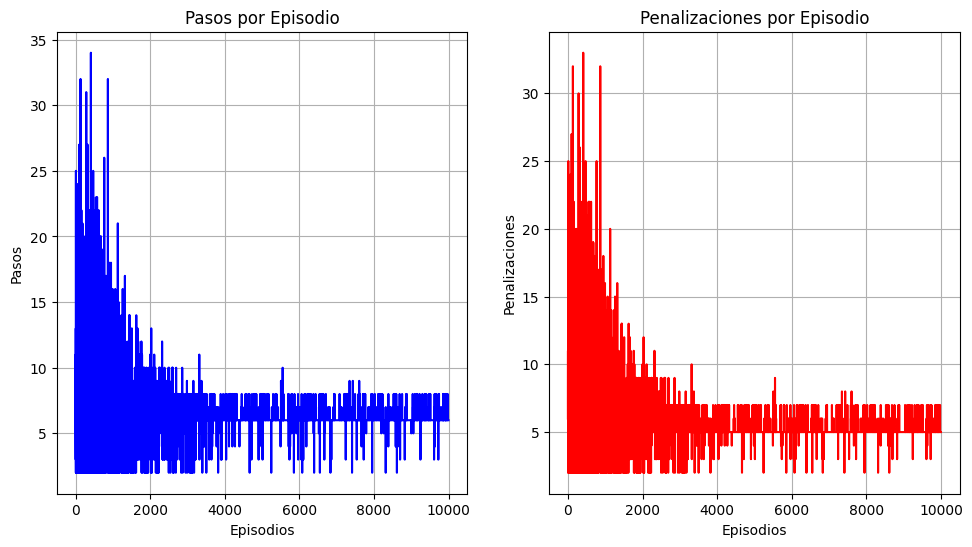

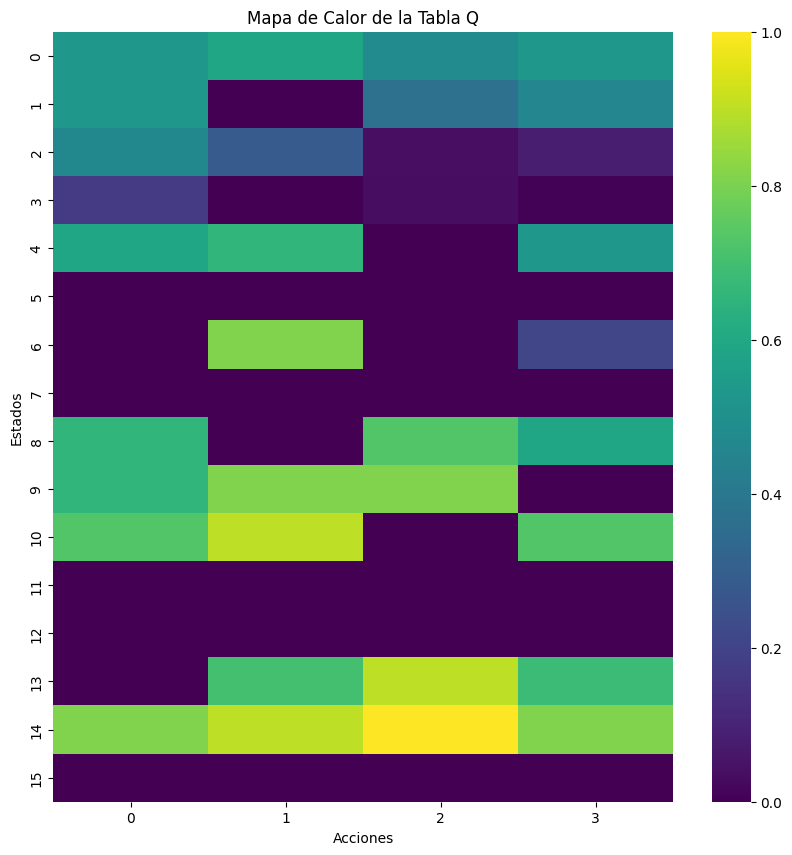

In [14]:
# Configuración de la visualización de las métricas
plt.figure(figsize=(18, 6))

# Gráfico para los pasos por episodio
plt.subplot(131)
plt.plot(all_timestep, color='blue')
plt.title('Pasos por Episodio')
plt.xlabel('Episodios')
plt.ylabel('Pasos')
plt.grid(True)

# Gráfico para las penalizaciones por episodio
plt.subplot(132)
plt.plot(all_penalties, color='red')
plt.title('Penalizaciones por Episodio')
plt.xlabel('Episodios')
plt.ylabel('Penalizaciones')
plt.grid(True)

# Heatmap de la tabla Q para visualizar cómo el agente valora las diferentes acciones desde cada estado
plt.figure(figsize=(10, 10))
sns.heatmap(q_table, annot=False, cmap="viridis", cbar=True)
plt.title('Mapa de Calor de la Tabla Q')
plt.xlabel('Acciones')
plt.ylabel('Estados')
plt.show()

# Documentación y Reporte Final

## Introducción

El objetivo de este proyecto es desarrollar y evaluar un agente de aprendizaje por refuerzo que pueda navegar eficazmente por el entorno "Frozen Lake", proporcionado por OpenAI Gym. Este entorno simula un lago congelado donde el agente debe encontrar un camino seguro desde el punto de partida hasta la meta sin caer en agujeros. Este problema representa un desafío clásico en aprendizaje por refuerzo debido a su naturaleza estocástica y la necesidad de equilibrar la exploración con la explotación para lograr un aprendizaje efectivo.

## Metodología

El algoritmo utilizado en este proyecto es Q-learning, un método de aprendizaje libre de modelos que busca maximizar la suma de recompensas futuras descuentadas al aprender la función de valor óptima, Q. Esta función es actualizada iterativamente durante cada episodio de entrenamiento siguiendo la ecuación:

\[ Q(s, a) \leftarrow Q(s, a) + \alpha [R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a)] \]

donde \(s\) es el estado actual, \(a\) es la acción tomada, \(R(s, a)\) es la recompensa recibida, \(s'\) es el estado siguiente, y \(a'\) son las posibles acciones en el estado siguiente. Los hiperparámetros utilizados incluyen:
- **Tasa de aprendizaje (\(\alpha\))**: 0.1
- **Factor de descuento (\(\gamma\))**: 0.9
- **Estrategia de exploración (Epsilon-greedy)** con \(\epsilon\) inicial de 1.0, decaimiento de 0.999 y un mínimo de 0.01.

## Configuración Experimental

El experimento fue realizado utilizando Python y la librería OpenAI Gym, que proporciona el entorno "Frozen Lake". Se estableció una configuración estocástica del entorno para simular condiciones realistas donde el agente puede deslizarse y caer en agujeros. Se realizaron 10,000 episodios de entrenamiento para permitir una adecuada convergencia de la política del agente.

## Resultados

A lo largo del entrenamiento, el agente mejoró gradualmente su capacidad para navegar por el lago hasta alcanzar un éxito consistente en encontrar la meta. El rendimiento del agente, medido en términos de la tasa de éxito y los pasos necesarios para alcanzar la meta, mostró una mejora significativa conforme progresaba el entrenamiento.

## Análisis

La visualización de la tabla Q a través de un mapa de calor indicó que el agente aprendió a valorar ciertas acciones más que otras en estados específicos, lo que sugiere una comprensión efectiva de las estrategias necesarias para navegar por el lago congelado. La política final del agente mostró una preferencia clara por caminos que maximizan la seguridad y la eficiencia.

## Conclusiones

El proyecto demostró la eficacia del algoritmo Q-learning en el aprendizaje de políticas óptimas en entornos estocásticos y desafiantes. Futuras direcciones para este trabajo podrían incluir la exploración de variantes de Q-learning, como Double Q-learning o Q-learning con aproximadores de función, para manejar mejor la incertidumbre y mejorar la generalización del aprendizaje del agente.

## Referencias

- Brockman, G., et al. (2016). OpenAI Gym. arXiv preprint arXiv:1606.01540.
- Sutton, R. S., & Barto, A. G. (2018). Reinforcement Learning: An Introduction. MIT press.
